In [1]:
%matplotlib inline
import sys
sys.path.append('../code')
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import colormaps
#import seaborn as sns
from sbi import inference as sbi_inference
#from utils import linear_scale_array
from hnn_core import jones_2009_model, calcium_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
import neo
import quantities as pq
from elephant import statistics, kernels
from scipy.signal import periodogram, welch
from sklearn.linear_model import LinearRegression
from fooof import FOOOF
from dask_jobqueue import SLURMCluster
import dask
from distributed import Client

import seaborn as sns
rng_seed = 123

scale_factor = 60_000

#sns.set()
#sns.set_style("white")

device = 'cpu'

data_path = f'../data'

# sim_name = 'connprob'
sim_name = 'conngscale'

# Load metadata
with open(f'{data_path}/noise_EI_{sim_name}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/noise_EI_{sim_name}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
#with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
#    posterior_metadata = dill.load(output_file)

dpl_grid = np.load(f'../data/noise_EI_{sim_name}/sbi_sims/dpl_grid.npy')
theta_grid = np.load(f'../data/noise_EI_{sim_name}/sbi_sims/theta_grid.npy')
#spike_gids = np.load(f'../data/noise_EI_{sim_name}/sbi_sims/spike_gids_grid.npy', allow_pickle=True)
#spike_times = np.load(f'../data/noise_EI_{sim_name}/sbi_sims/spike_times_grid.npy', allow_pickle=True)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
#window_samples = posterior_metadata['window_samples']
num_trials = dpl_grid.shape[0]

net = jones_2009_model()
gid_list = np.concatenate(list(net.gid_ranges.values()))

num_cores = 128

"""Reserve SLURM resources using Dask Distributed interface"""
 # Set up cluster and reserve resources
cluster = SLURMCluster(
    cores=32, processes=32, queue='shared', memory="256GB", walltime="10:00:00",
    job_extra_directives=['-A csd403', '--nodes=1'], log_directory=os.getcwd() + '/slurm_out')



/home/ntolley/anaconda3/envs/hnn_sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
--No graphics will be displayed.


In [2]:
client = Client(cluster)
client.cluster.scale(num_cores)
print(client.dashboard_link)

http://198.202.103.253:8787/status


In [3]:
# EI, EE, II, IE
sweep_idx = 0
sweep_vals = np.unique(theta_grid[:,0])

sim_indices = list()
for val in sweep_vals:
    sim_row = np.repeat(sweep_vals[5], 4)
    sim_row[sweep_idx] = val
    sim_idx = np.where((theta_grid == sim_row).all(axis=1))[0]
    sim_indices.append(sim_idx)
    
sim_indices = np.array(sim_indices).squeeze()

#np.where((vals == (0, 1)).all(axis=1))

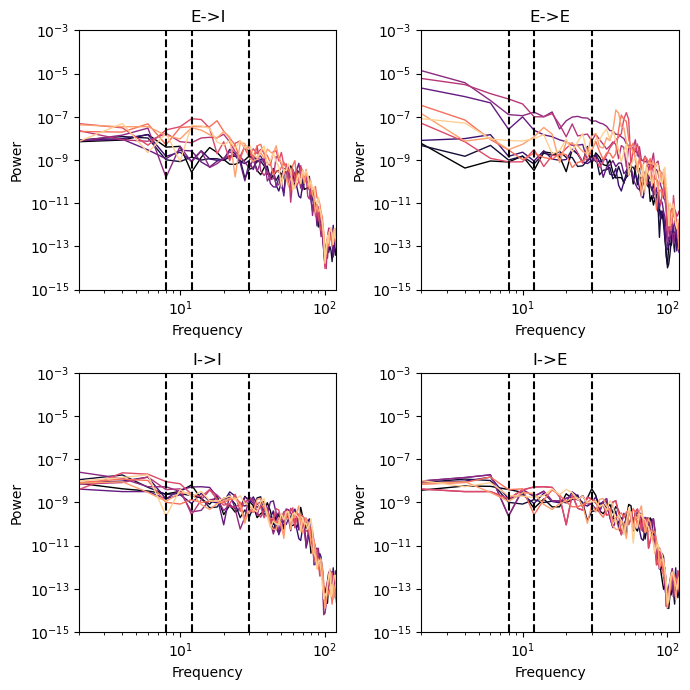

In [4]:
sfreq = 20_000
cm = colormaps['magma']
titles = ['E->I', 'E->E', 'I->I', 'I->E']

fixed_idx=2
plt.figure(figsize=(7,7))
for sweep_idx in range(4):
    plt.subplot(2,2,sweep_idx + 1)
    sweep_vals = np.unique(theta_grid[:,0])

    sim_indices = list()
    for val in sweep_vals:
        sim_row = np.repeat(sweep_vals[fixed_idx], 4)
        sim_row[sweep_idx] = val
        sim_idx = np.where((theta_grid == sim_row).all(axis=1))[0]
        sim_indices.append(sim_idx)

    sim_indices = np.array(sim_indices).squeeze()

    for color_idx, sim_idx in enumerate(sim_indices):
        color = cm(color_idx / 10)
        data = dpl_grid[sim_idx, :]
        freqs, Pxx = welch(data, sfreq, nperseg=10_000,average='median')
        plt.plot(freqs, Pxx, color=color, linewidth=1)

    for pos in [8,12,30]:
        plt.axvline(pos, color='k', linestyle='--')

    plt.xlim(2, 120)

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('Frequency')
    plt.ylabel('Power')
    
    plt.ylim(10e-16, 10e-4)
    
    plt.title(titles[sweep_idx])
    plt.tight_layout()
    

Text(0.5, 0, 'Time (ms)')

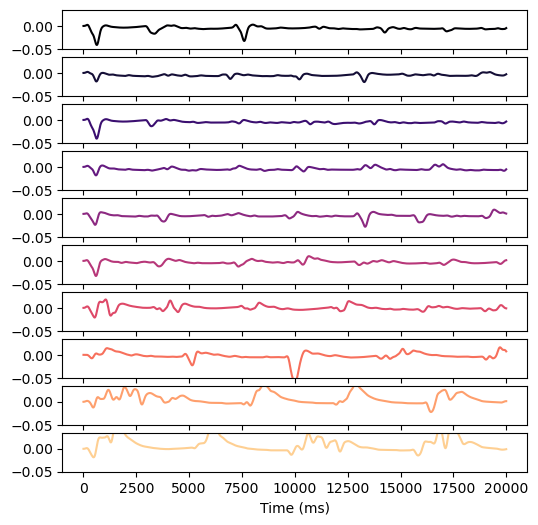

In [5]:
sim_indices = list()
sweep_idx = 2
fixed_idx = 7
for val in sweep_vals:
    sim_row = np.repeat(sweep_vals[fixed_idx], 4)
    sim_row[sweep_idx] = val
    sim_idx = np.where((theta_grid == sim_row).all(axis=1))[0]
    sim_indices.append(sim_idx)
sim_indices = np.array(sim_indices).squeeze()

        
plt.figure(figsize=(6,6))
time = np.linspace(0,1,dpl_grid.shape[1])
for color_idx, sim_idx in enumerate(sim_indices):
    plt.subplot(len(sim_indices), 1, color_idx+1)
    color = cm(color_idx / 10)
    data = dpl_grid[sim_idx, :]
    plt.plot(data, color=color)
    
    plt.ylim(-0.05, 0.035)
    
plt.xlabel('Time (ms)')
    

In [6]:
# fm = FOOOF(aperiodic_mode='knee')
# data = dpl_grid[2050, :]
# freqs, Pxx = welch(data, sfreq, nperseg=10_000, average='median', noverlap=5000)
# # Define frequency range across which to model the spectrum
# freq_range = [0, 80]

# # Model the power spectrum with FOOOF, and print out a report
# fm.report(freqs, Pxx, freq_range)



In [7]:
def psd_scalefree_slope(dpl, min_freq=30, max_freq=80):    
    # Get PSD
    sfreq = 20_000
    freqs, Pxx = welch(dpl, sfreq, nperseg=10_000, average='median')

    lm = LinearRegression()
    mask = np.logical_and(freqs > min_freq, freqs < max_freq)
    
    lm.fit(np.log(freqs[mask].reshape(-1,1)), np.log(Pxx[mask]).reshape(-1,1))
    
    return lm.coef_[0][0]


def get_aperiodic(dpl, min_freq=3, max_freq=80):
    fm = FOOOF()
    freqs, Pxx = welch(dpl, sfreq, nperseg=10_000, average='median', noverlap=5000)
    
    freq_range = [0, 80]
    # Define frequency range across which to model the spectrum
    fm.report(freqs, Pxx, freq_range)

    aperiodic_params = fm.get_results().aperiodic_params
    offset, exponent = aperiodic_params[0], aperiodic_params[1]
    
    return offset, exponent
    

In [8]:
res_list = []
for idx in range(dpl_grid.shape[0]):
    data = dpl_grid[idx,:]
    res = dask.delayed(get_aperiodic)(data)
    res_list.append(res)

# Run tasks
final_res = dask.compute(*res_list)

In [9]:
final_res_array = np.array(final_res)

In [10]:
df = pd.DataFrame(theta_grid, columns=['EI','EE','II','IE'])
df['offset'] = final_res_array[:,0]
df['exponent'] = final_res_array[:,1]
df.to_pickle(f'{sim_name}_fooof.pkl')

In [12]:
df

,EI,EE,II,IE,offset,exponent
0,0.05,0.05,0.05,0.05,-8.183845,1.056207
1,0.05,0.05,0.05,0.15,-8.678569,0.658442
2,0.05,0.05,0.05,0.25,-8.900303,0.664593
3,0.05,0.05,0.05,0.35,-8.568651,0.861583
4,0.05,0.05,0.05,0.45,-7.387906,1.720429
...,...,...,...,...,...,...
9995,0.95,0.95,0.95,0.55,-4.756589,1.171917
9996,0.95,0.95,0.95,0.65,-3.408747,2.017129
9997,0.95,0.95,0.95,0.75,-2.987086,2.332525
9998,0.95,0.95,0.95,0.85,-4.494508,1.859471


<AxesSubplot: xlabel='exponent', ylabel='EI'>

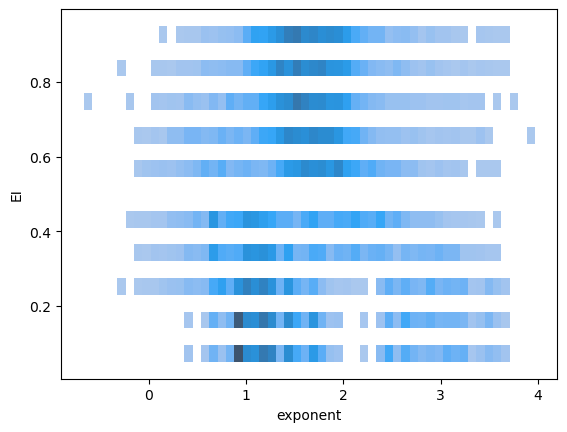

In [30]:
sns.histplot(data=df, x='exponent', y='EI')